In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

df = pd.read_csv('c://users//Sergi//proyectos//proyecto_final//data//processed//vehicles_with_model_clean.csv')


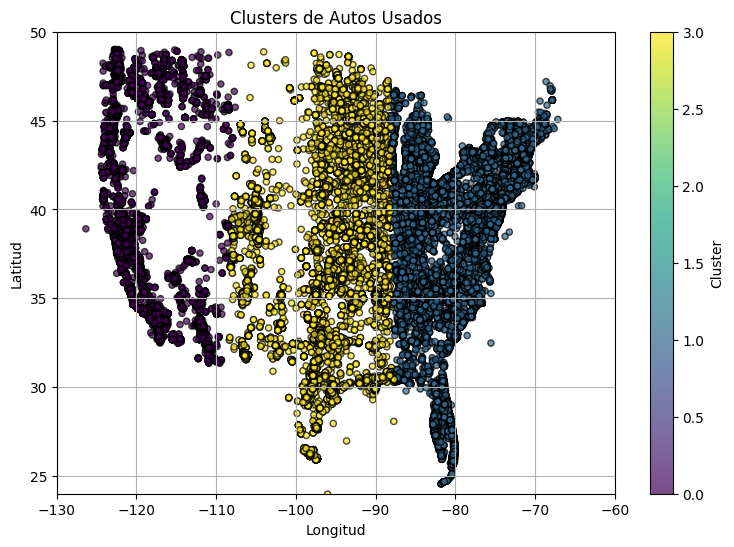

In [9]:
from sklearn.cluster import KMeans

# Extraer las coordenadas de latitud y longitud
coords = df[['lat', 'long']].values

# Definir el número de clusters
n_clusters = 4  # Puedes ajustar este valor según lo necesario

# Aplicar K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(coords)

# Añadir los labels de los clusters al DataFrame
df['cluster'] = kmeans.labels_

# Graficar los clusters
plt.figure(figsize=(9, 6))
plt.scatter(df['long'], df['lat'], c=df['cluster'], cmap='viridis', marker='o', s=20, alpha=0.7, edgecolor='k')
plt.title('Clusters de Autos Usados')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.xlim(-130, -60)
plt.ylim(24, 50)
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# Guardar los resultados en un nuevo archivo CSV
df.to_csv('c://users//Sergi//proyectos//proyecto_final//data//processed//archivo_cluster_KMeans.csv', index=False)


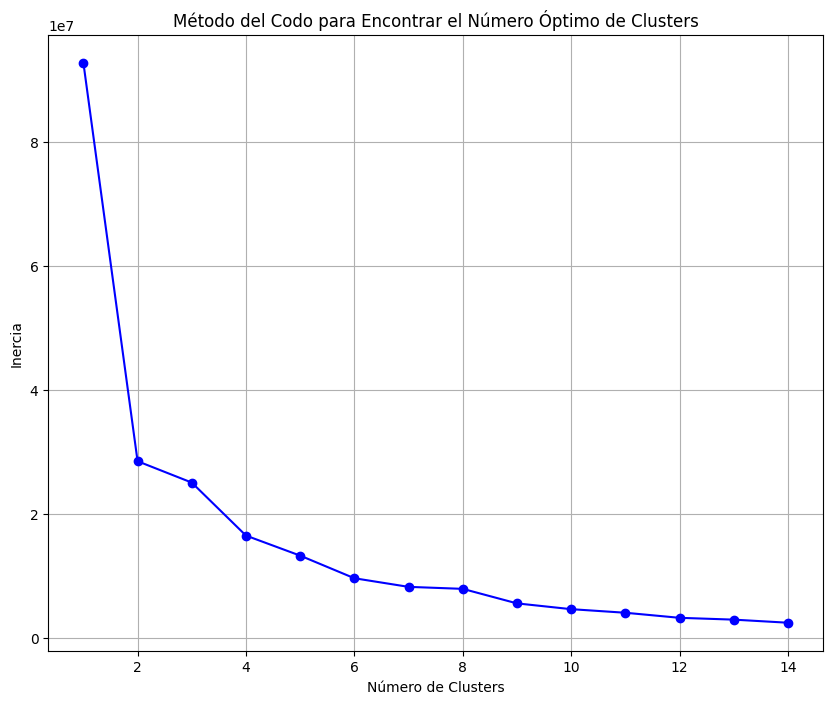

In [3]:
# Extraer las coordenadas de latitud y longitud
coords = df[['lat', 'long']].values

# Método del codo para determinar el número óptimo de clusters
inertia = []
K = range(1, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(coords)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(10, 8))
plt.plot(K, inertia, 'bo-')
plt.title('Método del Codo para Encontrar el Número Óptimo de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Convertir variables categóricas a dummy variables
DF_processed = pd.get_dummies(df)

# Estandarizar los datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(DF_processed)

# Reducir a 10 dimensiones usando PCA
pca = PCA(n_components=10)
data_pca = pca.fit_transform(data_scaled)


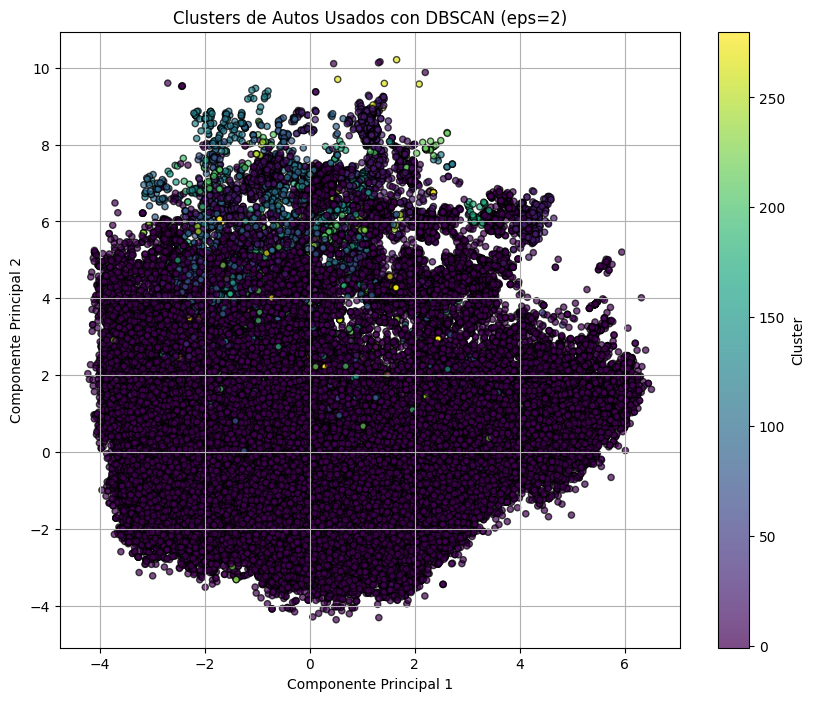

In [8]:
# Aplicar DBSCAN con eps=2 y min_samples=5
dbscan = DBSCAN(eps=2, min_samples=5).fit(data_pca)

# Añadir los labels de los clusters al DataFrame original
df['cluster'] = dbscan.labels_

# Graficar los clusters
plt.figure(figsize=(10, 8))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=df['cluster'], cmap='viridis', marker='o', s=20, alpha=0.7, edgecolor='k')
plt.title('Clusters de Autos Usados con DBSCAN (eps=2)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# Guardar los resultados en un nuevo archivo CSV
df.to_csv('c://users//Sergi//proyectos//proyecto_final//data//processed//archivo_clusters_dbscan.csv', index=False)


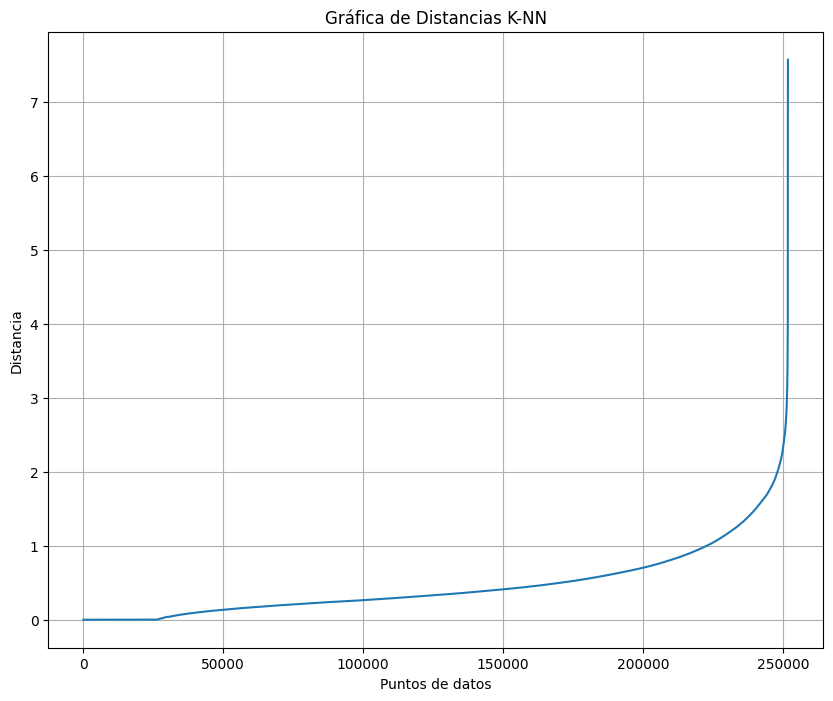

In [6]:
from sklearn.neighbors import NearestNeighbors

# Calcular las distancias K-NN
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(data_pca)
distances, indices = neighbors_fit.kneighbors(data_pca)

# Ordenar y graficar las distancias
distances = np.sort(distances[:, 4], axis=0)
plt.figure(figsize=(10, 8))
plt.plot(distances)
plt.title('Gráfica de Distancias K-NN')
plt.xlabel('Puntos de datos')
plt.ylabel('Distancia')
plt.grid(True)
plt.show()
